In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature
from tqdm.notebook import tqdm
import corner
%matplotlib notebook

<IPython.core.display.Javascript object>


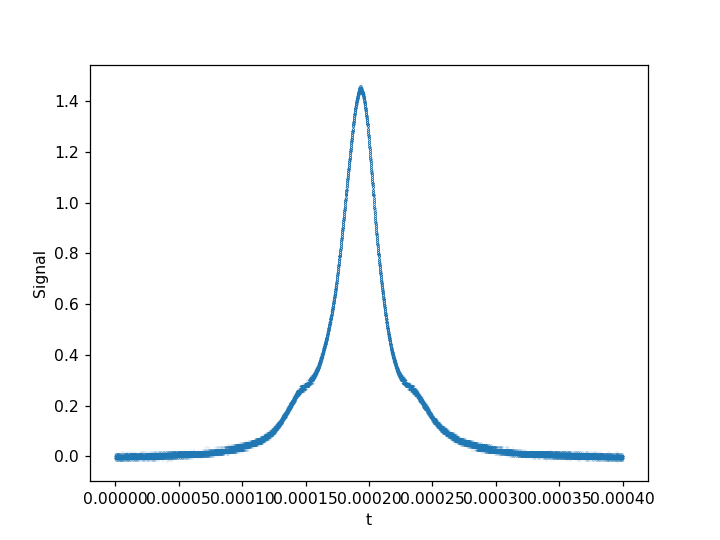

Text(0, 0.5, 'Signal')

In [2]:
data=np.load('mcmc/sidebands.npz')
t=data['time']
d=data['signal']
fig, ax = plt.subplots()
ax.plot(t,d,'.',markersize = 0.1,label = 'Data')
ax.set_xlabel('t')
ax.set_ylabel('Signal')

## a) 

To model our data and fita lorentzian of the form $d = \frac{a}{1+(t-t_0)^2/w^2}$, we need the derivative of $d(t,a,t_0,w)$ with respect to each parameter. This yields:

$d_a = \frac{w^2}{w^2+(t-t_0)^2}$<br>
$d_{t_0} = \frac{2aw^2(t-t_0)}{(w^2+(t-t_0)^2)^2}$<br>
$d_w = \frac{2aw(t-t_0)^2}{(w^2+(t-t_0)^2)^2}$<br>



Then, we can perform a fit using newton's method to minimize $\chi^2$ by solving for $\delta p$, which is the shift in our parameters that gets us closer to the minimum of the $\chi^2$ in parameter space, in the following equation $A_p^TN^{-1}A_p \delta p = A_pr$, where $A_p$ is the matrix of the gradient of the function we are fitting evaluated at each datapoint for a given set of parameters $p$, and $r$ is our residual vector. Here, we will consider N as diagonal and a multiple of the identity matrix and deal with noise estimations later.

We then want to perform this until the value of $\chi^2$ stops changing dramatically with each iteration. Hence, we iterate until the difference in $\chi^2$ for two subsequent iterations is less than 0.5.

Best fit parameters: a = 1.423, t_0 = 0.000192, w = -1.792e-05


<IPython.core.display.Javascript object>


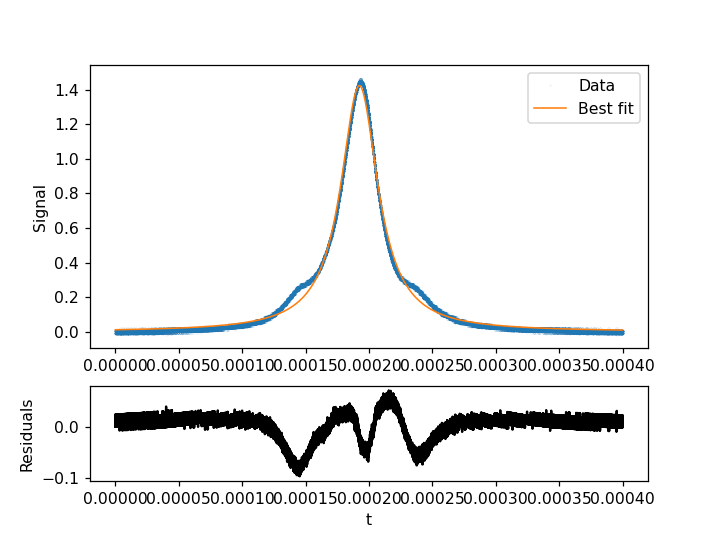

Text(0, 0.5, 'Residuals')

In [3]:
def calc_lorentz(p,t):
    y=p[0]/(1+(t-p[1])**2/p[2]**2)#model
    grad=np.zeros([t.size,p.size])
    #analytical derivatives
    grad[:,0]=p[2]**2/(p[2]**2+(t-p[1])**2)
    grad[:,1]=2*p[0]*p[2]**2*(t-p[1])/(p[2]**2+(t-p[1])**2)**2
    grad[:,2]=2*p[0]*p[2]*(t-p[1])**2/(p[2]**2+(t-p[1])**2)**2
    return y,grad

p0=np.array([1.4,0.00017,0.0001])#starting guess parameters
p=p0.copy()
errprev = 0
err = np.inf
while np.abs(err-errprev)>0.5:#until the tolerance is reached
    errprev = err
    pred,grad=calc_lorentz(p,t)#compute the model and gradient of chisquare
    r=d-pred #residuals
    err=(r**2).sum() #chisquare*sigma**2, when this stops changing, we know we have converged
    #perform newtons method
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)
    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for ii in range(p.size):#update the parameters 
        p[ii]=p[ii]+dp[ii]



print('Best fit parameters: a = {}, t_0 = {}, w = {}'.format(round(p[0],3),round(p[1],6),round(p[2],8)))

fit,grad = calc_lorentz(p,t)

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(t,d,'.',markersize = 0.1,label = 'Data')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Signal')
ax[0].plot(t,fit,linewidth = 1, label = 'Best fit')
ax[0].legend()
ax[1].plot(t,fit-d,'k',markersize = 0.1)
ax[1].set_ylabel('Residuals')

We can see that we have a somewhat reasonable fit given the limited model. This yields best fit parameters:

$a = 1.423, t_0 = 1.92\times 10^{-4}, w = -1.79\times 10^{-5}$

# b)

We can get an estimate of the noise by taking the mean of the absolute value of our residuals. This can help us estimate our noise matrix N as having entries $\sigma^2$ on the diagonal. Hence, to get an estimate of the error in our best fit parameters, we can take the square root of the entries on the diagonal of our covariance matrix $(A_p^TN^{-1}A_p)^{-1}$, which is $(A_p^TA_p)^{-1}\sigma^2$ for the case where $N = \sigma^2I$.

In [96]:
noise = np.mean(np.abs(fit-d))
cov = np.linalg.inv(lhs)*noise**2
perrs = np.sqrt(np.diag(cov))
noise,perrs

(0.012604138534029724,
 array([2.29917730e-04, 2.18458159e-04, 2.13757626e-04, 2.72737198e-09,
        4.87758820e-09, 3.34872206e-08]))

This yields a noise estimate of $\approx 0.02$, and parameter errors of $\sigma_a = 3\times10^{-4},\sigma_{t_0} = 4\times10^{-9},\sigma_w = 6\times10^{-9}$

# c)

To repeat this fit using numerical derivatives, we only need to compute the gradient numerically, to do this, we will define a function to compute the lorentzian and one to compute the gradient. We will approximate the derivative with respect to each parameter as $\frac{\partial d}{\partial p}\approx \frac{d(p+\delta p)-d(p)}{\delta p}$, with $\delta p = e_f^{1/3}p$, where $e_f$ is the machine precision, as I did in problem set 1 for my numerical differentiator, except that it is now performed with respect to all parameters through ndiff_multi. 

Best fit parameters:

a  =  1.4228114997658308 +/- 0.0002125308291749163
t_0  =  0.00019235866159008342 +/- 2.6764071396341222e-09
w  =  -1.7923670121446094e-05 +/- 3.790131632402399e-09


<IPython.core.display.Javascript object>


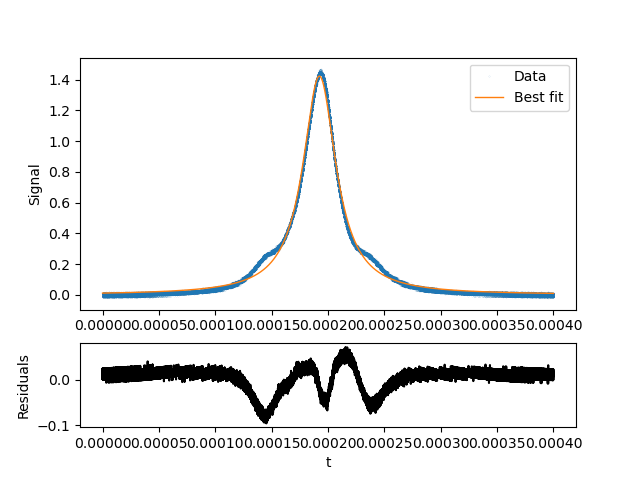

Text(0, 0.5, 'Residuals')

In [97]:
def lorentz(t,p): #now defining lorentzian separately
    return p[0]/(1+(t-p[1])**2/p[2]**2)

def ndiff_multi(fun,p,x):
    ef = 1e-16   
    dps = ef**(1/3)*p # computing the optimal dps
    #the following code adds the dp corresponding to each parameter and evaluates the function at the new location
    #in parameter space, then it computes the derivative, and repeats it for all parameters in fun
    dps = np.diag(dps) 
    grad = np.zeros([x.size,p.size])
    for i in range(len(p)):
        grad[:,i] = (fun(x,p+dps[i])-fun(x,p))/dps[i][i]
    return grad

#we perform the rest of newtons method as we did in part a)
def calc_lorentz(p,t):
    y=lorentz(t,p)
    grad = ndiff_multi(lorentz,p,t)
    return y,grad

p0=np.array([1.4,0.00017,0.0001])
p=p0.copy()
errprev = 0
err = np.inf
while np.abs(err-errprev)>0.5:
    errprev = err
    pred,grad=calc_lorentz(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)
    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    cov = np.linalg.inv(lhs)
    dp=cov*(rhs)
    for ii in range(p.size):
        p[ii]=p[ii]+dp[ii]
        
noise = np.mean(np.abs(fit-d))
cov = np.linalg.inv(lhs)*noise**2
perrs = np.sqrt(np.diag(cov))
noise,perrs

params = ['a','t_0','w']
print('Best fit parameters:\n')
for i in range(len(p)):
    print(params[i],' = ',p[i],'+/-',perrs[i])

fit,grad = calc_lorentz(p,t)

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(t,d,'.',markersize = 0.1,label = 'Data')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Signal')
ax[0].plot(t,fit,linewidth = 1, label = 'Best fit')
ax[0].legend()
ax[1].plot(t,fit-d,'k',markersize = 0.1)
ax[1].set_ylabel('Residuals')



We can see that we still have our best fit parameters $a  =  1.4228\pm 0.0003,
t_0  =  (1.92358 \pm 0.00004)\times10^{-4},
w  =  (-1.7924 \pm 0.0006)\times10^{-5}$ so this fit is not statistically significantly different from the one in part a).

# d)

We now attempt to better fit our data by using the following model:

$d = \frac{a}{1+(t-t_0)^2/w^2}+\frac{b}{1+(t-t_0+dt)^2/w^2}+\frac{c}{1+(t-t_0-dt)^2/w^2}$

We simply have to repat the same steps, but we know have 6 free parameters, so we redefine our functions lorentz and calc_lorentz from the previous fit to match this new model. Our function to compute the gradient can however remain the same.

In [98]:
def lorentz_mod(t,p): #modified lorentzian, it takes an argument p, which is the 6-parameter array ordered as a,b,c,t_0,w,dt
    A = p[0]/(1+(t-p[3])**2/p[4]**2) #first term
    B = p[1]/(1+(t-p[3]+p[5])**2/p[4]**2) #second term
    C = p[2]/(1+(t-p[3]-p[5])**2/p[4]**2) #third term
    return A+B+C

def calc_lorentz_mod(p,t):
    y=lorentz_mod(t,p)
    grad = ndiff_multi(lorentz_mod,p,t)
    return y,grad

Best fit parameters:

a  =  1.4430607675295761 +/- 0.00022991773026636366
b  =  0.10402337648436341 +/- 0.00021845815858282806
c  =  0.06513544610109202 +/- 0.00021375762621140437
t_0  =  0.00019257610622474967 +/- 2.7273719767688526e-09
w  =  -1.6056408807112016e-05 +/- 4.877588204939203e-09
dt  =  4.445170752753218e-05 +/- 3.348722055212439e-08


<IPython.core.display.Javascript object>


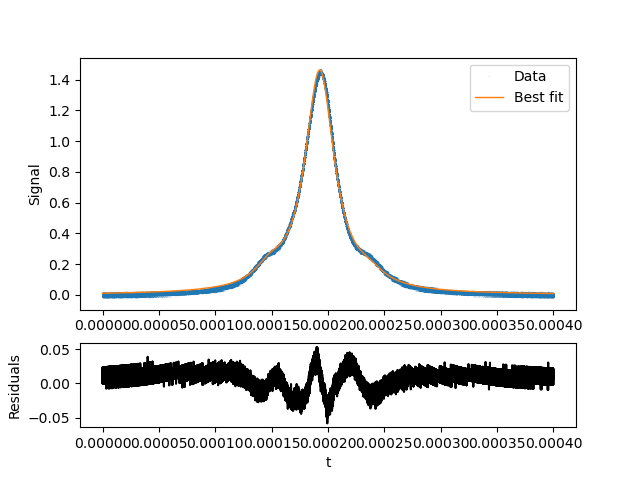

Text(0, 0.5, 'Residuals')

In [99]:
#perform newtons method

p0=np.array([1.423,1.423/5,1.423/5,0.00019,-1.792e-5,0.00005])
p=p0.copy()
errprev = 0
err = np.inf
while np.abs(err-errprev)>0.5:
    errprev = err
    pred,grad=calc_lorentz_mod(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)
    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    cov = np.linalg.pinv(lhs)
    dp=cov*(rhs)
    for ii in range(p.size):
        p[ii]=p[ii]+dp[ii]

fit,grad = calc_lorentz_mod(p,t)

noise = np.mean(np.abs(fit-d))
cov = np.linalg.inv(lhs)*noise**2
perrs = np.sqrt(np.diag(cov))
noise,perrs

params = ['a','b','c','t_0','w','dt']
print('Best fit parameters:\n')
for i in range(len(p)):
    print(params[i],' = ',p[i],'+/-',perrs[i])

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(t,d,'.',markersize = 0.1,label = 'Data')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Signal')
ax[0].plot(t,fit,linewidth = 1, label = 'Best fit')
ax[0].legend()
ax[1].plot(t,fit-d,'k',markersize = 0.1)
ax[1].set_ylabel('Residuals')



Doing the same as before for the parameter errors, we obtain the following:

$a = 1.4431\pm0.0002$<br>
$b = 0.1040\pm0.0002$<br>
$c = 0.0651\pm0.0002$<br>
$t_0 = (1.92576\pm0.00003)\times10^{-4}$<br>
$w = (-1.60564\pm0.00005)\times10^{-4}$<br>
$dt = (4.445\pm0.003)\times10^{-5}$<br>

# e) 

Looking at the residuals from part d), we can clearly see that there is structure, i.e., the residuals do not look like white noise. Indeed, there is a sort of wiggle in the middle that indicates that our model is not a good description of the data, and that something else is at play here, perhaps correlated noise.

# f)

using the covariance matrix, we can simulate multiple sets of parameters that are generated in accordance to the covariance of the parameters. If the parameters were not correlated, this would reduce to making each parameter vary gaussianly in accordance to its error bar. However, since the covariance matrix is not diagonal, we need to generate these series of parameters respecting this correlation. We can generate such realizations of the noise with np.random.multivariate_normal(p,cov), where p is our parameter vector and cov is the covariance matrix. Then, we can plot what the fit looks like for each set of parameters. (they look really similar, but if we look closely they are distinct). Below, we perform this for 100 different sets of parameters.

<IPython.core.display.Javascript object>


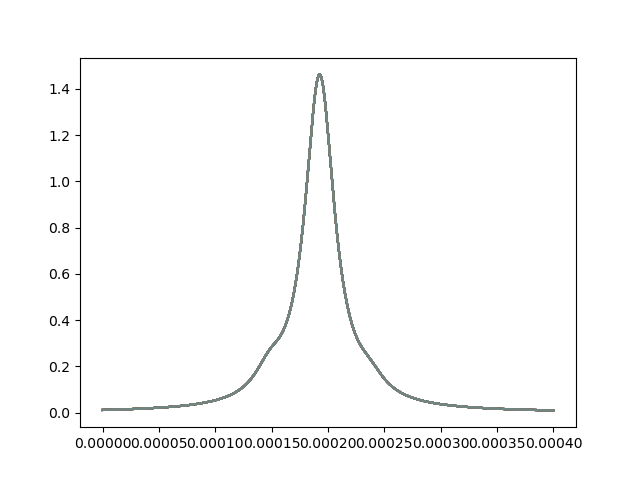

Best fit chisquare is 133763.33452795108, and chisquare for different realization of the noise is 9.349339250181801


In [100]:
varparams = np.random.multivariate_normal(p,cov,100)

fig, ax = plt.subplots()
ax.plot(t,lorentz_mod(t,p),alpha = 0.2)


bestfit_chisq = np.sum((fit-d)**2)/noise**2
varfits_chisq = np.zeros(len(varparams))

for i in range(len(varparams)):
    varfit = lorentz_mod(t,varparams[i])
    chisq = np.sum((varfit-d)**2)/noise**2
    varfits_chisq[i] = chisq
    ax.plot(t,varfit,alpha = 0.2)
    
perrs = np.std(varparams,axis = 0)
typ_diff = np.mean(abs(varfits_chisq-bestfit_chisq))
print('Best fit chisquare is {}, and chisquare for different realization of the noise is {}'.format(bestfit_chisq,typ_diff))

We can see that our best fit $\chi^2$ is on the order of 10^5, which makes sense as we have 10^5 datapoints. When we perturb our parameters, we have a typical change in chisquare of between 6 and 10 usually. This makes sense, as we perturb our parameters according to the covariance matrix, and since we have 6 free parameters, perturbing them will bump up $\chi^2$ by something on the order of the number of parameters. We can verify that this is the case by repeating this with the fit with 3 parameters (which is not done here, but I have done it on the side), and we can see that the typical difference with the best fit $\chi^2$ is closer to 3.

# g)

We now perform the fit through an MCMC. We will want to take our steps in accordance with the correlation in our parameters, so the trial steps of the MCMC will be generated like we generated the noise in the parameters in part f). We can then scale these steps to tune them such that our MCMC performs nicely. We can use the parameters from the Newton's method fit, and let our parameters wander around in parameter space.

In [9]:
def get_chisq(fun,pars,noise):
    fit = fun(t,pars)
    chisq = np.sum((fit-d)**2/noise**2)
    return chisq

def get_step(pars,cov,scale):
    return np.random.multivariate_normal(np.zeros(len(pars)),cov)*scale

def run_chain(fun,pars,noise,cov,data,scale,nstep=20000,T=1):
    accepted = 0
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chisq=np.zeros(nstep)
    chain[0,:]=pars
    chi_cur=get_chisq(fun,pars,noise)
    chisq[0]=chi_cur
    for i in tqdm(range(1,nstep)):
        pp=pars+get_step(pars,cov,scale)
        new_chisq=get_chisq(fun,pp,noise)
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        if np.random.rand(1)<accept_prob:
            accepted+=1
            pars=pp
            chi_cur=new_chisq
        chain[i,:]=pars
        chisq[i]=chi_cur
    accrate = accepted/nstep
    return chain,chisq,accrate

In [11]:
chain,chisq,accrate = run_chain(lorentz_mod,p,noise,cov,d,scale = 1,nstep = 30000)

In [12]:
print('The acceptance rate was {} %'.format(accrate*100))

The acceptance rate was 26.02 %


We see that the acceptance rate is around 25%, which is pretty sound. We can now confirm that our chain has converged by plotting the value of each parameter at every iteration

<IPython.core.display.Javascript object>


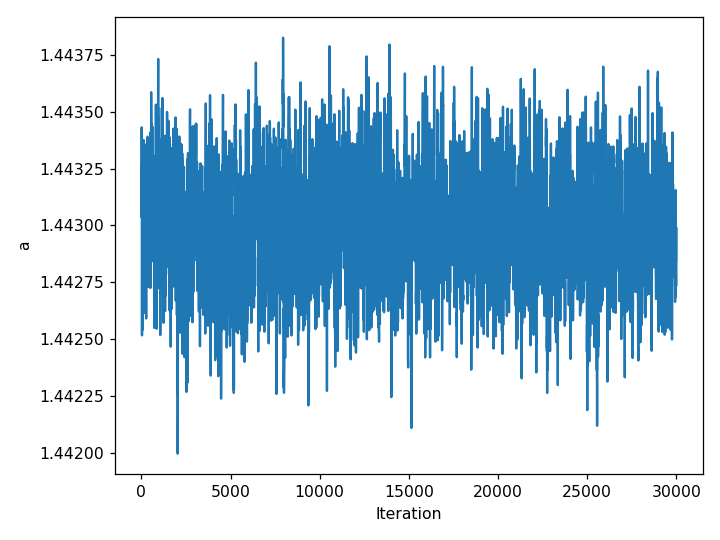

<IPython.core.display.Javascript object>


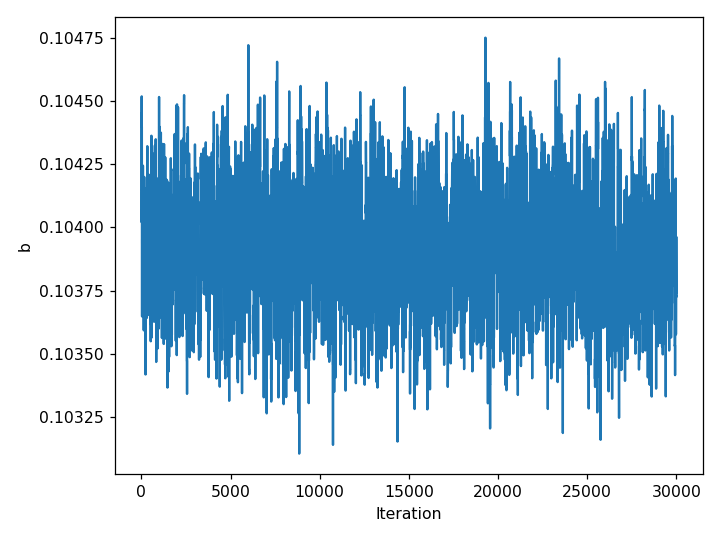

<IPython.core.display.Javascript object>


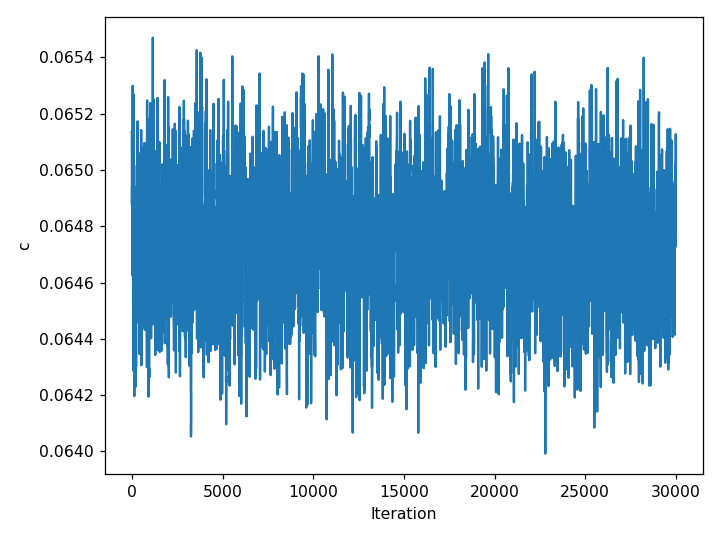

<IPython.core.display.Javascript object>


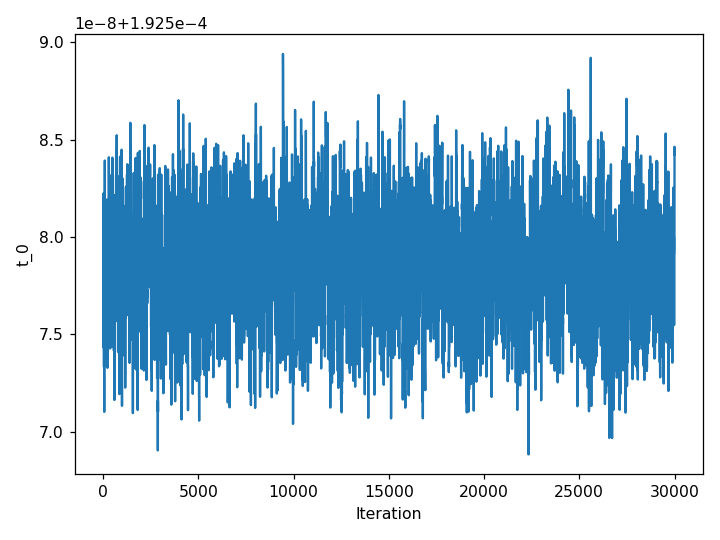

<IPython.core.display.Javascript object>


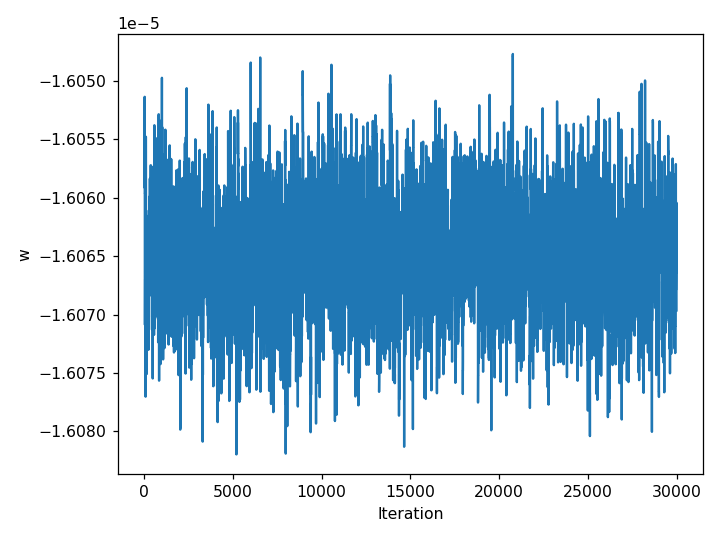

<IPython.core.display.Javascript object>


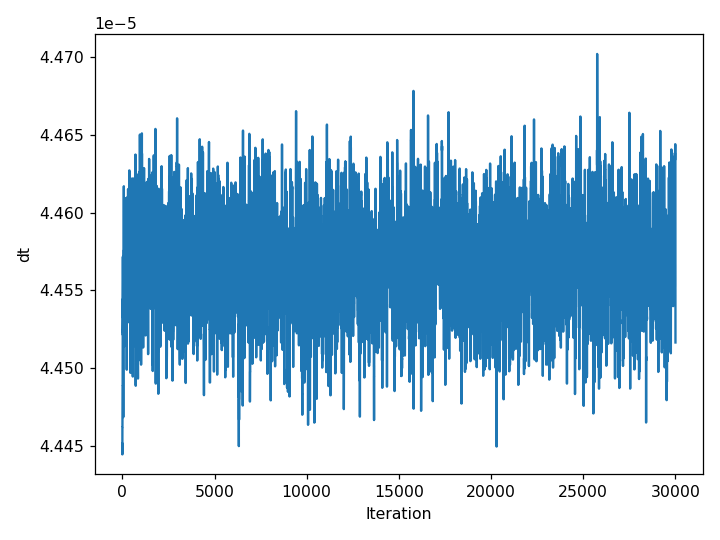

In [13]:
burnin = 1000

for i in range(np.shape(chain)[1]):
    fig,ax = plt.subplots()
    ax.plot(chain[:,i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel(params[i])
    fig.tight_layout()
pmcmc = np.mean(chain[burnin:], axis = 0)
pmcmc_errs = np.std(chain[burnin:], axis = 0)

Indeed, every chain looks like white noise, so we can be pretty confident that our chain has converged. Because we have these chains, we can also plot the corner plots to look at parameter correlations.

<IPython.core.display.Javascript object>


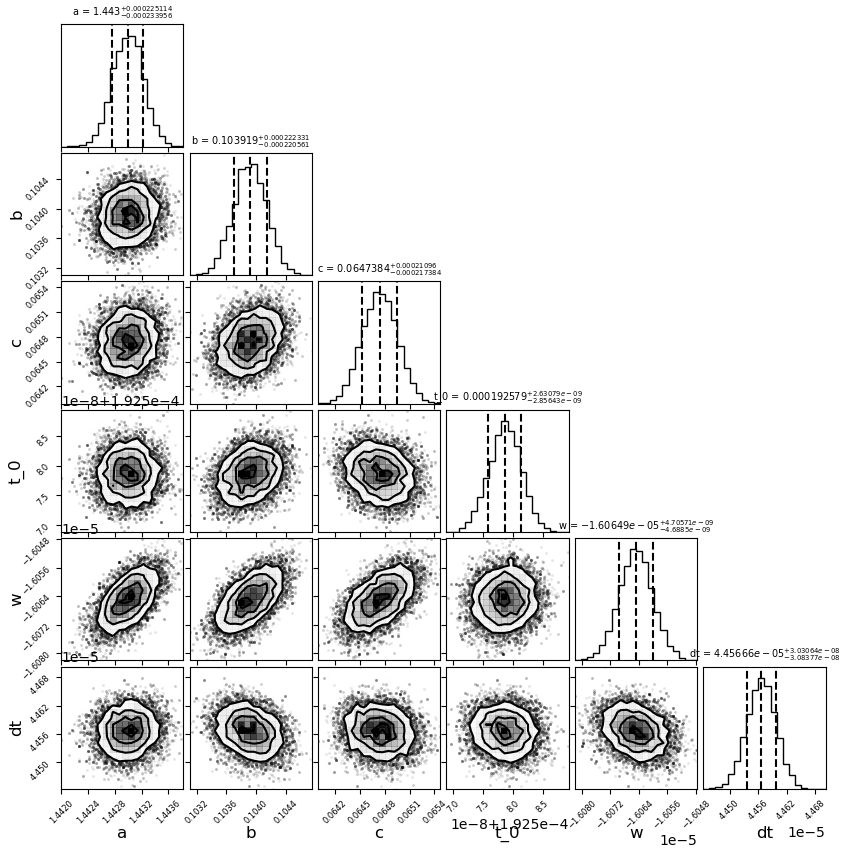

In [69]:
fig = corner.corner(chain,labels = params,label_kwargs=dict(fontsize=12),quantiles = [0.16,.5,.84],show_titles=True,title_fmt='g',title_kwargs = dict(fontsize = 7))

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=6)
fig.set_size_inches((8.5,8.5))

Let us now plot both models with the parameters from Newtons method and from the MCMC.

<IPython.core.display.Javascript object>


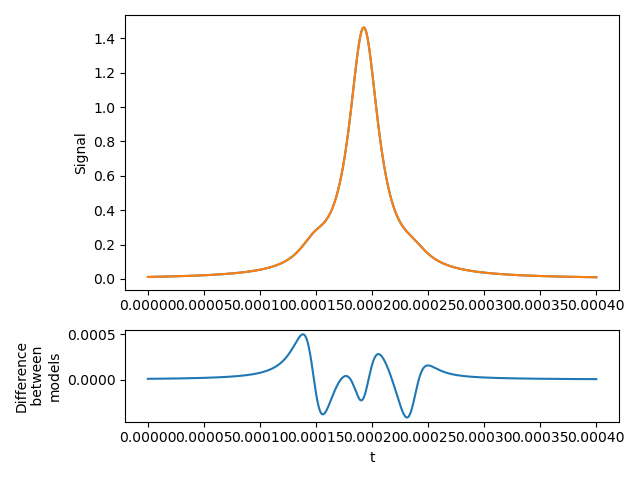

In [101]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(t,lorentz_mod(t,p))
ax[0].plot(t,lorentz_mod(t,pmcmc))
ax[1].plot(t,lorentz_mod(t,pmcmc)-lorentz_mod(t,p))
ax[0].set_ylabel('Signal')
ax[1].set_ylabel('Difference\n between \nmodels')
ax[1].set_xlabel('t')
fig.tight_layout()

In [72]:
print('Best fit parameters for Newtowns method:\n')
for i in range(len(p)):
    print(params[i],' = ',p[i],'+/-',perrs[i])
print('\nBest fit parameters for MCMC:\n')
for i in range(len(p)):
    print(params[i],' = ',pmcmc[i],'+/-',pmcmc_errs[i])
       

Best fit parameters for Newtowns method:

a  =  1.4430607675295761 +/- 0.00024099158167484368
b  =  0.10402337648436341 +/- 0.0002212621397244128
c  =  0.06513544610109202 +/- 0.00022947138937755732
t_0  =  0.00019257610622474967 +/- 2.416623110030381e-09
w  =  -1.6056408807112016e-05 +/- 4.727165757439882e-09
dt  =  4.445170752753218e-05 +/- 3.272061597292919e-08

Best fit parameters for MCMC:

a  =  1.4429926372220647 +/- 0.00023141789797819762
b  =  0.1039174823924944 +/- 0.0002221712884101363
c  =  0.06473822806538998 +/- 0.00021136076174477428
t_0  =  0.00019257864867662278 +/- 2.74513915639308e-09
w  =  -1.6064917536969086e-05 +/- 4.747027158691162e-09
dt  =  4.456634769914663e-05 +/- 3.053799494976274e-08


We see that the errors in our parameters stay the same, and the parameters themselves change a little bit, but stay pretty much the same.

# h)

We know that $dt$ maps to 9GHz, but $dt$ has units of time so we need to take the inverse of $dt$, find the mapping relation between the two and find what $w$ maps to in GHz. Hence $W = w^{-1}\cdot9GHz/dt^{-1}$. Of course, w came up as negative in our fit, so we need to take the absolute value, but it comes up as squared in the model so it doesnt really matter.

In [113]:
dt = pmcmc[-1]
w = abs(pmcmc[-2])
dterr = pmcmc_errs[-1]
werr = pmcmc_errs[-2]

W = w**-1*9e9/dt**-1
W_err = W*np.sqrt(np.sum(np.array([werr/w,dterr/dt])**2))

print(W/9e9,'+/-',W_err/9e9)

2.7741410808109763 +/- 0.0020701272142164325


We find that $W = 2.774\pm0.002\ GHz$